# Losses

A collection of losses including:

- Spectral log magnitude loss
- Spectral convergence loss
- Wasserstein loss


In [ ]:
# | default_exp losses

In [ ]:
# | exporti

import jax.numpy as jnp
import jax

In [ ]:
# | hide

import matplotlib.pyplot as plt

In [ ]:
# | export


def quantile_function(qs, cws, xs):
    r"""Computes the quantile function of an empirical distribution

    Parameters
    ----------
    qs: array-like, shape (n,)
        Quantiles at which the quantile function is evaluated
    cws: array-like, shape (m, ...)
        cumulative weights of the 1D empirical distribution, if batched, must be similar to xs
    xs: array-like, shape (n, ...)
        locations of the 1D empirical distribution, batched against the `xs.ndim - 1` first dimensions

    Returns
    -------
    q: array-like, shape (..., n)
        The quantiles of the distribution
    """
    n = xs.shape[0]
    cws = cws.T
    qs = qs.T
    idx = jnp.searchsorted(cws, qs).T
    return jnp.take_along_axis(xs, jnp.clip(idx, 0, n - 1), axis=0)


def wasserstein_1d(
    u_values,
    v_values,
    u_weights=None,
    v_weights=None,
    p=1,
    require_sort=True,
):
    r"""

    This is a port of the wasserstein_1d function from [POT](https://pythonot.github.io/_modules/ot/lp/solver_1d.html#wasserstein_1d) in JAX.
    Computes the 1 dimensional OT loss [15] between two (batched) empirical
    distributions

    .. math:
        OT_{loss} = \int_0^1 |cdf_u^{-1}(q) - cdf_v^{-1}(q)|^p dq

    It is formally the p-Wasserstein distance raised to the power p.
    We do so in a vectorized way by first building the individual quantile functions then integrating them.

    This function should be preferred to `emd_1d` whenever the backend is
    different to numpy, and when gradients over
    either sample positions or weights are required.

    Parameters
    ----------
    u_values: array-like, shape (n, ...)
        locations of the first empirical distribution
    v_values: array-like, shape (m, ...)
        locations of the second empirical distribution
    u_weights: array-like, shape (n, ...), optional
        weights of the first empirical distribution, if None then uniform weights are used
    v_weights: array-like, shape (m, ...), optional
        weights of the second empirical distribution, if None then uniform weights are used
    p: int, optional
        order of the ground metric used, should be at least 1 (see [2, Chap. 2], default is 1
    require_sort: bool, optional
        sort the distributions atoms locations, if False we will consider they have been sorted prior to being passed to
        the function, default is True

    Returns
    -------
    cost: float/array-like, shape (...)
        the batched EMD

    References
    ----------
    .. [15] Peyré, G., & Cuturi, M. (2018). Computational Optimal Transport.

    """

    assert p >= 1, "The OT loss is only valid for p>=1, {p} was given".format(p=p)

    n = u_values.shape[0]
    m = v_values.shape[0]

    if u_weights is None:
        u_weights = jnp.full(u_values.shape, 1.0 / n, dtype=u_values.dtype)
    elif u_weights.ndim != u_values.ndim:
        u_weights = jnp.repeat(u_weights[..., None], u_values.shape[-1], -1)
    if v_weights is None:
        v_weights = jnp.full(v_values.shape, 1.0 / m, dtype=v_values.dtype)
    elif v_weights.ndim != v_values.ndim:
        v_weights = jnp.repeat(v_weights[..., None], v_values.shape[-1], -1)

    if require_sort:
        u_sorter = jnp.argsort(u_values, 0)
        u_values = jnp.take_along_axis(u_values, u_sorter, 0)

        v_sorter = jnp.argsort(v_values, 0)
        v_values = jnp.take_along_axis(v_values, v_sorter, 0)

        u_weights = jnp.take_along_axis(u_weights, u_sorter, 0)
        v_weights = jnp.take_along_axis(v_weights, v_sorter, 0)

    u_cumweights = jnp.cumsum(u_weights, 0)
    v_cumweights = jnp.cumsum(v_weights, 0)

    qs = jnp.sort(jnp.concatenate((u_cumweights, v_cumweights), 0), 0)
    u_quantiles = quantile_function(qs, u_cumweights, u_values)
    v_quantiles = quantile_function(qs, v_cumweights, v_values)
    qs = jnp.pad(qs, pad_width=[(1, 0)] + (qs.ndim - 1) * [(0, 0)])
    delta = qs[1:, ...] - qs[:-1, ...]
    diff_quantiles = jnp.abs(u_quantiles - v_quantiles)

    if p == 1:
        return jnp.sum(delta * diff_quantiles, axis=0)
    return jnp.sum(delta * jnp.power(diff_quantiles, p), axis=0)

In [ ]:
# | export


def compute_mag(
    x: jnp.ndarray,  # (b, t)
) -> jnp.ndarray:
    # Compute the magnitude rfft
    return jnp.abs(jnp.fft.rfft(x, axis=-1, norm="forward"))

In [ ]:
# | export


def spectral_wasserstein(
    x,
    y,
    squared=True,
    is_mag=False,
):
    if is_mag:
        x_mag = x if not squared else x**2
        y_mag = y if not squared else y**2
    else:
        x_mag = compute_mag(x) if not squared else compute_mag(x) ** 2
        y_mag = compute_mag(y) if not squared else compute_mag(y) ** 2

    # we need to normalise the mag_ffts so that they represent distributions
    x_mag = x_mag / jnp.sum(x_mag)
    y_mag = y_mag / jnp.sum(y_mag)

    x_pos = jnp.linspace(0, 1, x_mag.shape[-1])

    return wasserstein_1d(
        x_pos,
        x_pos,
        x_mag,
        y_mag,
    )


batched_spectral_wasserstein = jax.vmap(spectral_wasserstein)

In [ ]:
# | export


def log_mag(
    x: jnp.ndarray,
    eps: float = 1e-10,
):
    return jnp.log(jnp.abs(x) + eps)


def log_mag_loss(
    pred: jnp.ndarray,  # complex valued fft of the signal
    target: jnp.ndarray,  # complex valued fft of the signal
    eps: float = 1e-10,
    distance: str = "l1",
):
    """
    Spectral log magtinude loss but for a fft of a signal
    See [Arik et al., 2018](https://arxiv.org/abs/1808.06719)
    """

    pred_log_mag = log_mag(pred, eps)
    target_log_mag = log_mag(target, eps)

    # l1 spectral log magnitude loss
    if distance == "l1":
        return jnp.mean(jnp.abs(pred_log_mag - target_log_mag))
    # l2 spectral log magnitude loss
    elif distance == "l2":
        return jnp.mean((pred_log_mag - target_log_mag) ** 2)
    else:
        raise ValueError("Invalid distance metric. Choose 'l1' or 'l2'.")

In [ ]:
phase = 0.0
omegas = jax.random.uniform(jax.random.PRNGKey(0), shape=(10,)) * 100
mag = 0.99


def osc_bank(t, omegas):
    return mag * jnp.sin(omegas[..., None] * jnp.pi * 2 * t[None] + phase)

In [ ]:
t = jnp.linspace(0, 1, 1000)
gt_osc_values = osc_bank(t, omegas)
# print(gt_osc_values)
print(gt_osc_values.shape)

(10, 1000)


In [ ]:
a = jax.vmap(spectral_wasserstein)(gt_osc_values, gt_osc_values)
print(a)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def loss_fn(omega):
    pred_osc_values = osc_bank(t, omega)
    x_fft = compute_mag(gt_osc_values)
    y_fft = compute_mag(pred_osc_values)
    l2_mag_loss = jnp.mean((x_fft - y_fft) ** 2)
    return l2_mag_loss


def ot_loss_fn(omega):
    pred_osc_values = osc_bank(t, omega)

    ot_loss = jnp.mean(
        jax.vmap(spectral_wasserstein)(gt_osc_values, pred_osc_values),
    )
    return ot_loss

[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

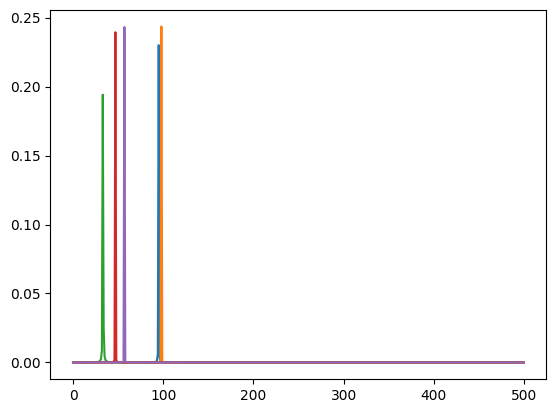

In [ ]:
x_fft = compute_mag(gt_osc_values) ** 2
plt.plot(x_fft[:5].T)

(100,) float32
(100,) float32


[<matplotlib.lines.Line2D>]

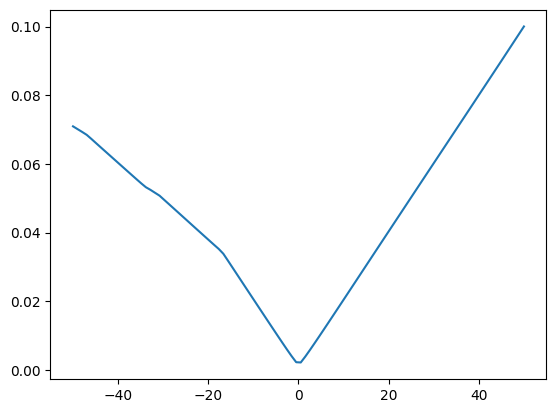

In [ ]:
ranges = jnp.linspace(-50, 50, 100)
omegas_scan = omegas + ranges[:, None]

# print(omegas_scan.shape)
loss, grad = jax.vmap(jax.value_and_grad(loss_fn))(omegas_scan)
loss_ot, grad_ot = jax.vmap(jax.value_and_grad(ot_loss_fn))(omegas_scan)

print(loss.shape, loss.dtype)
print(loss_ot.shape, loss_ot.dtype)
plt.plot(ranges, loss_ot)

[<matplotlib.lines.Line2D>]

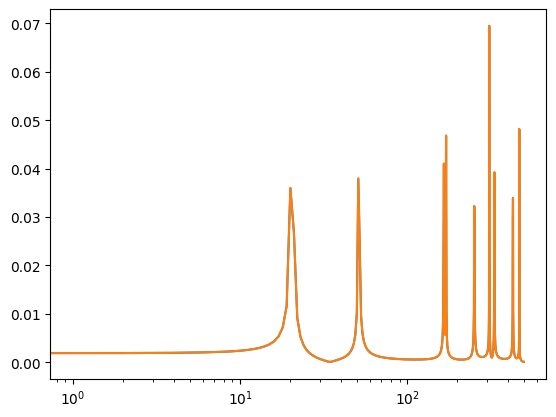

In [ ]:
omegas_gt = jax.random.uniform(jax.random.PRNGKey(0), shape=(10,)) * 1000
omegas_pred = omegas_gt * 1

pred_osc_values = osc_bank(t, omegas_pred).mean(axis=0)
gt_osc_values = osc_bank(t, omegas_gt)

x_mag = compute_mag(gt_osc_values.mean(axis=0))
y_mag = compute_mag(pred_osc_values)

plt.semilogx(x_mag)
plt.semilogx(y_mag)

In [ ]:
# | export
def spectral_convergence_loss(
    pred: jnp.ndarray,  # magnitude of the fft of the predicted signal
    target: jnp.ndarray,  # magnitude of the fft of the target signal
):
    """
    Spectral convergence loss but for a fft of a signal
    See [Arik et al., 2018](https://arxiv.org/abs/1808.06719)
    """
    # l2 spectral convergence loss
    return jnp.linalg.norm(target - pred) / jnp.linalg.norm(target)